# Нейросетевые методы в обработке текстовых данных

## Домашнее задание 3. RNN архитектуры

### Дарья Матяш БКЛ-181


**жирным** выделены мои комментарии к заданию


В этой домашке будем разбираться с RNN и учиться работать со статьями, я нашла для вас вот такую достаточно уже старую, но при этом несложно написанную, статью с хорошо описанными экспериментами, в современных реалиях, она конечно не state of the art, но она хорошо подойдет для наших целей.

прочитайте статью https://arxiv.org/pdf/1511.08630.pdf
мы будем ставить эксперименты на других данных, поэтому, проанализируйте и сделайте препроцессинг на основании вашего анализа и того дизайна экспериментов, который описан в статье, для этого датасета https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv
Задача: предсказать категорию новости (там есть дополнительная колонка, не обращаем внимание, что это датасет fakenews, в этом дз нас интересует тематика новости)

3) реализуйте на pytorch ту архитектуру модели, которую в итоге тестировали авторы (подробное описание есть в статье), таким образом, чтобы это был пайплайн для проведения экспериментов: можно было запускать модель с разными гиперпараметрами, разными способами регуляризации, описанными в статье (в том числе, чтобы можно было вставлять ее в разных местах), паддингом, векторизацией.
(**ниже реализация и параметры по умолчанию - из статьи**)

4) поставьте эксперименты с разными параметрами и особенностями архитектуры (регуляризация, паддинг, векторизация, драпаут и тд, в статье подробно описан смысл этих операций и что конкретно делали, загуглите как это имплементировано в торче) так как описано в статье (там есть подробное описание в разделе 5.2 Experimental Settings )  (**ниже реализация и параметры по умолчанию - из статьи**)

5) оцените результаты экспериментов также, как это сделали в статье (**accuracy**)

6) напишите выводы (это должно быть похоже на раздел Results and Model Analysis только не нужно сравнивать с другими моделями, как это делают авторы статьи, сравнивайте только результаты своих экспериментов, потому что там цифры на других датасетах. Да писать так много тоже не нужно, но у вас и должно получиться меньше потому что не будет сравнения)

Если вы хотите дополнительный балл:

реализуйте классы для RNN, LSTM и GRU ячейки
реализуйте класс RNN слоя
Если вы хотите еще один дополнительный балл, то используйте в экспериментах не RNN слой из торча, а свой самочинный слой, с разными типами ячеек (то есть поставьте дополнительные эксперименты не только с LSTM слоем, но и с обычным RNN и GRU слоем)

у меня есть опция выбора эмбеддингов: 
* учить модель на word2vec из статьи или пользоваться просто nn.Embedding()
* можно выбирать позицию дропаута (где "навесить")
* можно 

In [2]:
pip install torchmetrics

     |████████████████████████████████| 332 kB 5.6 MB/s 


In [4]:
!wget https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv

--2021-12-15 15:45:54--  https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘fake-and-real-news-dataset?select=Fake.csv’

fake-and-real-news-     [ <=>                ]  53.19K  --.-KB/s    in 0.05s   

2021-12-15 15:45:54 (1.02 MB/s) - ‘fake-and-real-news-dataset?select=Fake.csv’ saved [54463]



In [7]:
ls

'fake-and-real-news-dataset?select=Fake.csv'   Fake.csv   sample_data/


In [38]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from collections import Counter
from typing import List
from sklearn.model_selection import train_test_split
from typing import List
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader


from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torchmetrics.functional import precision, recall, f1

import gensim
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Примечание:** Датасет Fake.csv должен лежать в той же папке, что и тетрадка  (то же самое далее про загруженный предобученный вердувек)



In [12]:
df = pd.read_csv('./Fake.csv')
df.head(3)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"


In [13]:
def bt(token_pattern=r'(?u)\b\w\w+\b')-> List:
    return re.compile(token_pattern).findall
tokenizer=bt()
print(tokenizer('HelLOO ToDaY +7904 fghakbm ? ! ***'))
 

def tokenize_line(line:str) -> List:
    if isinstance(line, str):
        line = ' '.join(tokenizer(line))
        line = re.sub('[0-9]', '', line)
        line = [w.lower() for w in line.split() if len(w)<20 and w not in stopwords_list]
        return line
    else:
        return 0

print(tokenize_line('HelLOO ToDaY +7904 fghakbm ? ! ***'))

['HelLOO', 'ToDaY', '7904', 'fghakbm']
['helloo', 'today', 'fghakbm']


In [14]:
df['tokens'] = df['text'].apply(tokenize_line)
df = df[df['tokens'] != 0].reset_index()
all_toks = []
for t in df['tokens']:
  all_toks.extend(t)
all_toks_counter = Counter(all_toks)

print('Число токенов, полученных первым способом, встретившихся в корпусе не более 5 раз: ',
      len([v for v in all_toks_counter.values() if v < 5]))

Число токенов, полученных первым способом, встретившихся в корпусе не более 5 раз:  53700


In [15]:
all_toks_counter.most_common(10)

[('trump', 79805),
 ('the', 60238),
 ('said', 33763),
 ('president', 27804),
 ('people', 26589),
 ('one', 24590),
 ('would', 23566),
 ('it', 19842),
 ('clinton', 19211),
 ('obama', 18836)]

Категориальные данные сделаем числовыми

In [16]:
# в этой домашке я перестала пользоваться LabelEncoder-ом,
# потому что забыла, как им пользоваться, а в гугле была такая прелесть для пандаса
c = df.subject.astype('category')
d = dict(enumerate(c.cat.categories))
print (d)
df['target'] = df.subject.astype('category').cat.codes
df.head(3)

{0: 'Government News', 1: 'Middle-east', 2: 'News', 3: 'US_News', 4: 'left-news', 5: 'politics'}


,index,title,text,subject,date,tokens,target
0,0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017","[donald, trump, wish, americans, happy, new, y...",2
1,1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017","[house, intelligence, committee, chairman, dev...",2
2,2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017","[on, friday, revealed, former, milwaukee, sher...",2


Просто посмотрим на соотношения классов

In [17]:
df[['target', 'text']].groupby('target').count()

,text
target,
0,1570
1,778
2,9050
3,783
4,4459
5,6841


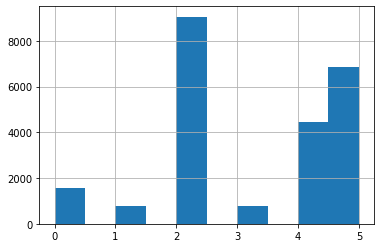

In [18]:
df['target'].hist()

Какой-то очень существенный дисбаланс данных, скорее всего, классы 1, 3 и ,возможно, 0 будут чаще предсказываться другими классами, возможно, самыми многочиленными.

Теперь разобьём данные (стратифицированно, чтобы не было перекосов с и так несбаланасированным датасетом) и создадим словарики для преобразований токенов в числа и наоборот для дальнейшей работы.

In [19]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['target'], shuffle=True, random_state=10)

In [20]:
word2id = {'PAD':0}

for word in all_toks_counter.keys():
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}
print(f'Число уникальных токенов - {len(word2id)}')

Число уникальных токенов - 88094


In [21]:
df.tokens

0        [donald, trump, wish, americans, happy, new, y...
1        [house, intelligence, committee, chairman, dev...
2        [on, friday, revealed, former, milwaukee, sher...
3        [on, christmas, day, donald, trump, announced,...
4        [pope, francis, used, annual, christmas, day, ...
                               ...                        
23476    [st, century, wire, says, as, wire, reported, ...
23477    [st, century, wire, says, it, familiar, theme,...
23478    [patrick, henningsen, st, century, wireremembe...
23479    [st, century, wire, says, al, jazeera, america...
23480    [st, century, wire, says, as, wire, predicted,...
Name: tokens, Length: 23481, dtype: object

In [22]:
class MyDataset(Dataset):
    # в прошлой домашке я не учла, что хорошо бы передавать
    # название текстовой и таргетной колонки, когда сдала, поняла, что переделаю в этот раз!!!
    # делаем ограничение на максимальную длину последовательности
    def __init__(self, dataset, text, target, word2id, max_len, device):
        self.dataset = dataset[text].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.device = device
        self.max_len = max_len
        self.target = torch.Tensor(dataset[target].values)
    
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx): 
        tokens = self.dataset[idx]
        ids = torch.LongTensor([self.word2id[tok] for tok in tokens if tok in self.word2id])
        y = [self.target[idx]]
        return ids, y

    # пишу этот метод сюда, потом при итерации по батчам пригодится
    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y


В статье написано, что авторы используют максимальную длину предложения из трейна, ниже закомменченая строка как ее посчитать. Дело в том, что максимальная длина это больше 6000 токенов, она не влезает в гпу колаба даже с батчом 32 при обучении, поэтому я для ДЗ поставила маленькую длину последовательности

В статье max_len = 6000 токенов, но я, так как не могу в колаб протащить такие длинные последовательности, поставила свою другую максимальную длину последовательности (беру среднюю длину)

In [63]:
max_len = int(np.mean(df.tokens.apply(lambda x: len(x))))
max_len

250

# Dataset, Dataloader

In [64]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

train_dataset = MyDataset(dataset=train_df,
                        text='tokens',
                        target='target',
                        word2id=word2id,
                        max_len=max_len,
                        device=device)

test_dataset = MyDataset(dataset=test_df,
                        text='tokens',
                        target='target',
                        word2id=word2id,
                        max_len=max_len,
                        device=device)

train_sampler = RandomSampler(train_dataset)

test_sampler = RandomSampler(test_dataset)

train_dataloader = DataLoader(train_dataset,
                            collate_fn = train_dataset.collate_fn,
                            sampler=train_sampler,
                            batch_size=batch_size)

test_dataloader = DataLoader(test_dataset,
                            collate_fn = test_dataset.collate_fn,
                            sampler=test_sampler,
                            batch_size=batch_size)

In [65]:
for ids, y in test_dataloader:
    print(ids, y)
    break

tensor([[10321,  5956,  5957,  ...,     0,     0,     0],
        [ 7955, 36341, 10054,  ...,     0,     0,     0],
        [  220,  2317,  1191,  ...,     0,     0,     0],
        ...,
        [  592,   605,  6909,  ...,     0,     0,     0],
        [  218,   219,   906,  ...,     0,     0,     0],
        [ 5797,  5678, 16887,  ...,     0,     0,     0]], device='cuda:0') tensor([[5.],
        [4.],
        [2.],
        [5.],
        [0.],
        [2.],
        [5.],
        [4.],
        [4.],
        [1.],
        [3.],
        [5.],
        [2.],
        [2.],
        [2.],
        [4.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [5.],
        [5.],
        [2.],
        [4.],
        [0.],
        [4.],
        [2.],
        [3.],
        [0.],
        [3.]], device='cuda:0')


Скачиваем вектора [отсюда](https://code.google.com/archive/p/word2vec/)

In [66]:
# ! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [67]:
google_news_path = "GoogleNews-vectors-negative300.bin.gz"
w2v = gensim.models.KeyedVectors.load_word2vec_format(google_news_path, binary=True)

"We initialize word vectors with the publicly available word2vec vectors1
that are pre-trained using
about 100B words from the Google News Dataset.
The dimensionality of the word vectors is 300. We
also initialize the word vector for the unknown
words from the uniform distribution [-0.25, 0.25].
We then fine-tune the word vectors along with other
model parameters during training."

In [68]:
w2v_weights = np.zeros((len(word2id), 300))

for word, i in word2id.items():
    try:
        w2v_weights[i] = w2v[word]    
    except KeyError:
        w2v_weights[i] = torch.FloatTensor((300,)).uniform_(-0.25, 0.25)

In [69]:
w2v_weights = torch.FloatTensor(w2v_weights)

* we apply CNN to text data and feed consecutive window features directly to LSTM, and so
our architecture enables LSTM to learn long-range
dependencies from higher-order sequential features

* the number of filters of length 3 is set to
be 150 and the memory dimension of LSTM is set
to be 150, too. The word vector layer and the LSTM
layer are dropped out with a probability of 0.5. For
TREC, the number of filters is set to be 300 and the
memory dimension is set to be 300. The word vector layer and the LSTM layer are dropped out with
a probability of 0.5. We also add L2 regularization
with a factor of 0.001 to the weights in the softmax
layer for both tasks

* feature
maps of CNN are organized as sequential window
features to serve as the input of LSTM. In this way,
instead of constructing LSTM directly from the
input sentence, we first transform each sentence
into successive window (n-gram) features to help
disentangle factors of variations within sentences.
We choose sequence-based input other than relying
on the syntactic parse trees before feeding in the
neural network, thus our model doesn’t rely on
any external language knowledge and complicated
pre-processing.

* beautiful [Github](https://github.com/bamtercelboo/cnn-lstm-bilstm-deepcnn-clstm-in-pytorch/blob/master/models/model_CLSTM.py)

In [70]:
num_classes = len(df['target'].unique())
num_classes

6

# C-LSTM Model

In [134]:
class CLSTM(torch.nn.Module):
    # тут прописаны дефолтные по статье значения
    def __init__(self, vocab_size,
                 embedding_size=300,
                 output_dim=num_classes,
                 max_len=max_len,
                 filter_sizes=[2, 3, 4],
                 num_filters=150,
                 memory_dim = 150,
                 lstm_layers = 1,
                 dropout_places = set([0]),
                 dropout_p=0.5,
                 pretrained_weights=True,
                 weights=w2v_weights, use_weights=True):
        
        super().__init__()
        # dropout_places здесь на каком моменте делать дропаут
        # можно использовать еще флаг, например
        self.dropout_places = dropout_places
        
        # максимальную длину я определила, как посчитала нужным
        self.max_len = max_len
        # размеры фильтров - тоже параметр для перебора :)
        self.filter_sizes = filter_sizes
        # будем экспериментировать с числом фильтров!
        self.num_filters = num_filters
        # учитываем проблемы с размерностями
        self.max_features = self.max_len - max(self.filter_sizes) + 1
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.pretrained_weights = pretrained_weights
        if use_weights:
        # замороженные веса-вордувеки 
          self.embeddings = nn.Embedding.from_pretrained(weights)
        else:
          self.embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
        # эта абракадабра мне понятна, но просто god bless гитхабы с разборами статей и с кодами
        windows = []
        for f in self.filter_sizes:
            conv = nn.Conv1d(in_channels=self.embedding_size,
                             out_channels=self.num_filters,
                             kernel_size=f,
                             padding='valid')
            windows.append(conv)
        self.windows = nn.ModuleList(windows)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_p)
        self.lstm = nn.LSTM(input_size=len(filter_sizes)* num_filters,
                            hidden_size=memory_dim,
                            num_layers=lstm_layers,
                            batch_first=True) #на первом месте в размерности - размерность батча
        self.linear = nn.Linear(memory_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embeds = self.embeddings(x).permute(0, 2, 1)
        # по умолчанию только так навешиваем дропаут, пулинг не делается ни в коем случае!!!!
        if 0 in self.dropout_places:
            embeds = self.dropout(embeds)
        # feature_maps
        feature_windows = []
        for conv in self.windows:
            feature_map = self.activation(conv(embeds))[:, :, :self.max_features]
            feature_windows.append(feature_map)
            
        feature_windows = torch.cat(feature_windows, 1).transpose(1,2)
        _, (state, _)= self.lstm(feature_windows)
        # если в сете есть еще навешивание дропаута на лстм, тут тоже так сработает
        if 1 in self.dropout_places:
            embedded = self.dropout(state)
        output = self.softmax(self.linear(torch.squeeze(state, 0)))
        
        return output

# Train, Evaluate functions

In [84]:
def train(train_dataloader, val_dataloader,
          model, optimizer,
          criterion, epochs,
          metric=accuracy, scheduler=None,
          verbose=False,
          device=device):

  losses = [] 
  accs = []
  val_losses = []
  val_accs = []

        
  for epoch in tqdm(range(epochs)):
        # training
        print(f'Epoch {epoch+1}:')
        train_loss, train_metric = train_epoch(train_dataloader, model, criterion, metric, device)
        losses.append(train_loss)
        accs.append(train_metric)

        
        #validation
        val_loss, val_metric = evaluate(val_dataloader, model, criterion, metric, device)
        val_losses.append(val_loss)
        val_accs.append(val_metric)

    
        model.train()
        if scheduler:
            if type(scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
                scheduler.step(val_loss)
            else:
                scheduler.step()
        print('----------')
  return losses, val_losses, accs, val_accs



def train_epoch(dataloader, model, criterion, metric=f1, device=device, verbose=False):
    model.train()  
    model.to(device)
    epoch_loss = []
    epoch_metric = []

    for x, y in train_dataloader:
            preds = model(x)
            y = y.flatten().type(torch.LongTensor).to(device)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            epoch_loss.append(loss.item())
            batch_metric = metric(preds.argmax(1).long(), y.long(), average='weighted', num_classes=6, ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())
    print(f'TRAIN Loss: {round(np.mean(epoch_loss), 2)}, TRAIN Metric: {round(np.mean(epoch_metric), 2)}')
    return np.mean(epoch_loss), np.mean(epoch_metric)
    
   

def evaluate(dataloader, model, criterion, metric, device, return_mean=False,):
    epoch_loss = []
    epoch_metric = []
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            preds = model(x)
            y = y.flatten().type(torch.LongTensor).to(device)
            loss = criterion(preds, y)
            epoch_loss.append(loss.item())
            batch_metric = metric(preds.argmax(1).long(), y.long(), average='weighted', num_classes=6, ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())
    print(f'VAL Loss: {round(np.mean(epoch_loss), 2)}, VAL Metric: {round(np.mean(epoch_metric), 2)}')
    return np.mean(epoch_loss),  np.mean(epoch_metric)

In [85]:
# Проверка работы кросс-энтропии
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
print(input, input.dtype)
target = torch.empty(3, dtype=torch.long).random_(5)
print(target,  target.dtype, target.shape)
output = loss(input, target)
print(output)

tensor([[-1.4840,  0.7671,  1.5113, -1.6606, -0.5010],
        [-0.1242, -0.6457, -0.3469, -0.9875,  0.8861],
        [-1.5425,  1.0133,  0.0282, -0.5295, -0.2971]], requires_grad=True) torch.float32
tensor([0, 4, 2]) torch.int64 torch.Size([3])
tensor(1.9590, grad_fn=<NllLossBackward0>)


# Эксперимент 1

In [124]:
model = CLSTM(len(word2id))
#базовые из статьи параметры (цитирование выше было)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
n_epochs = 10
losses, val_losses, accs, val_accs = train(train_dataloader,
                                                                           test_dataloader,
                                                                           model,
                                                                           optimizer,
                                                                           criterion,
                                                                           epochs=n_epochs,
                                                                           metric=accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
TRAIN Loss: 1.48, TRAIN Metric: 0.6000000238418579


 10%|█         | 1/10 [01:25<12:48, 85.41s/it]

VAL Loss: 1.44, VAL Metric: 0.6499999761581421
----------
Epoch 2:
TRAIN Loss: 1.44, TRAIN Metric: 0.6399999856948853


 20%|██        | 2/10 [02:51<11:25, 85.72s/it]

VAL Loss: 1.44, VAL Metric: 0.6499999761581421
----------
Epoch 3:
TRAIN Loss: 1.43, TRAIN Metric: 0.6499999761581421


 30%|███       | 3/10 [04:15<09:56, 85.17s/it]

VAL Loss: 1.43, VAL Metric: 0.6499999761581421
----------
Epoch 4:
TRAIN Loss: 1.43, TRAIN Metric: 0.6499999761581421


 40%|████      | 4/10 [05:42<08:34, 85.76s/it]

VAL Loss: 1.43, VAL Metric: 0.6499999761581421
----------
Epoch 5:
TRAIN Loss: 1.43, TRAIN Metric: 0.6600000262260437


 50%|█████     | 5/10 [07:04<07:01, 84.30s/it]

VAL Loss: 1.43, VAL Metric: 0.6499999761581421
----------
Epoch 6:
TRAIN Loss: 1.43, TRAIN Metric: 0.6600000262260437


 60%|██████    | 6/10 [08:26<05:34, 83.51s/it]

VAL Loss: 1.43, VAL Metric: 0.6600000262260437
----------
Epoch 7:
TRAIN Loss: 1.43, TRAIN Metric: 0.6600000262260437


 70%|███████   | 7/10 [09:49<04:09, 83.32s/it]

VAL Loss: 1.43, VAL Metric: 0.6499999761581421
----------
Epoch 8:
TRAIN Loss: 1.42, TRAIN Metric: 0.6600000262260437


 80%|████████  | 8/10 [11:13<02:47, 83.52s/it]

VAL Loss: 1.42, VAL Metric: 0.6600000262260437
----------
Epoch 9:
TRAIN Loss: 1.42, TRAIN Metric: 0.6600000262260437


 90%|█████████ | 9/10 [12:38<01:24, 84.06s/it]

VAL Loss: 1.43, VAL Metric: 0.6499999761581421
----------
Epoch 10:
TRAIN Loss: 1.42, TRAIN Metric: 0.6600000262260437


100%|██████████| 10/10 [14:00<00:00, 84.03s/it]

VAL Loss: 1.42, VAL Metric: 0.6499999761581421
----------


In [125]:
# all_preds_true = []
# all_preds_true.append([preds, true])
# ALLMETRICS = []
# ALLMETRICS.append([accs, val_accs])
# ALLLOSSES = []
# ALLLOSSES.append([losses, val_losses])

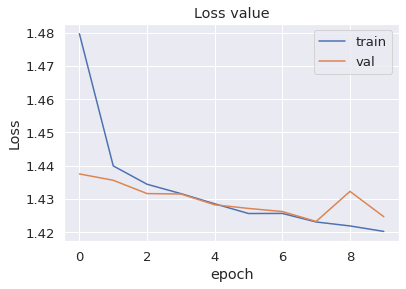

In [126]:
plt.plot(losses)
plt.plot(val_losses)
plt.title('Loss value')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

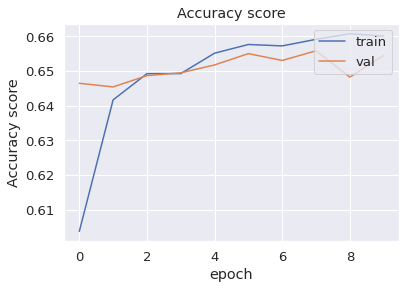

In [127]:
plt.plot(accs)
plt.plot(val_accs)

plt.title('Accuracy score')
plt.ylabel('Accuracy score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [129]:
preds = []
true = []
for texts, y in test_dataloader:   
    preds.extend(torch.argmax(model(texts), dim=1).cpu().detach().numpy())
    true.extend(y.cpu().detach().numpy())
print(classification_report(true, preds))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       314
         1.0       0.00      0.00      0.00       156
         2.0       0.78      0.94      0.85      1810
         3.0       0.00      0.00      0.00       157
         4.0       0.00      0.00      0.00       892
         5.0       0.46      0.84      0.60      1368

    accuracy                           0.61      4697
   macro avg       0.21      0.30      0.24      4697
weighted avg       0.43      0.61      0.50      4697



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


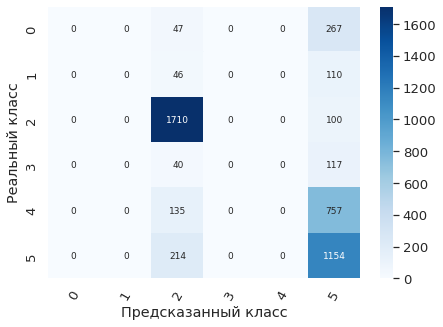

In [130]:
y_pred = preds
y_test = true
plt.figure(figsize=(7,5))
array=confusion_matrix(y_test, y_pred)
a = [sorted(test_df['target'].unique())]
df_cm = pd.DataFrame(array, index=a, columns=a)
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={'size':9}, cmap='Blues',fmt='g')
plt.xticks(rotation=60)
plt.xlabel('Предсказанный класс')
plt.ylabel('Реальный класс')
# plt.savefig('image.png')
plt.show()

Первая итерация получилась не очень приятной, ничего, статья-то старая, данные у нас другие, еще *несбалансированные*, поэтому для начала попробуем кросс-энтропию с весами, как раз для учета всех классов
веса в кросс-энтропию положим - обратную частоту встречаемости класса. Не только малочисленные классы, как предполагалось, плохо будут "найдены" моделью, но еще и не самые маленькие тоже модель не отловила. Да, модель просто часто предсказывала маленькие классы одним из больших классов - 5 или 2, ((( Попробуем это побороть!

Как будто даже немножко случилось переобучение модельки, не очень хорошо( но какие наши годы!

In [108]:
class_freqs = df['target'].value_counts().to_dict()
all_freqs = np.sum(list(class_freqs.values()))

ce_weights_dict = {key: 1/value/all_freqs for key, value in sorted(class_freqs.items())}
print(ce_weights_dict)
ce_weights = [value for key, value in sorted(ce_weights_dict.items())]
print(ce_weights)

{0: 2.7125875182455417e-08, 1: 5.4739876653541134e-08, 2: 4.705814810658012e-09, 3: 5.4390324439917e-08, 4: 9.55093609249944e-09, 5: 6.225350685054087e-09}
[2.7125875182455417e-08, 5.4739876653541134e-08, 4.705814810658012e-09, 5.4390324439917e-08, 9.55093609249944e-09, 6.225350685054087e-09]


In [111]:
# Проверка работы кросс-энтропии
loss = nn.CrossEntropyLoss(weight=torch.Tensor(ce_weights))
input = torch.randn(3, 6, requires_grad=True)
print(input, input.dtype)
target = torch.empty(3, dtype=torch.long).random_(6)
print(target,  target.dtype, target.shape)
output = loss(input, target)
print(output)

tensor([[-1.1534,  0.6130,  0.3429,  0.8646, -0.0056,  1.1138],
        [-0.0393,  0.4848,  1.2859,  0.1265, -0.6485, -1.9184],
        [-0.7137,  2.0307, -0.0334, -0.2575,  0.1915,  0.4473]],
       requires_grad=True) torch.float32
tensor([3, 5, 2]) torch.int64 torch.Size([3])
tensor(1.7623, grad_fn=<NllLossBackward0>)


# Эксперимент 2

In [113]:
model = CLSTM(len(word2id))
#базовые из статьи параметры (цитирование выше было)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(ce_weights).to(device))
n_epochs = 10
losses, val_losses, accs, val_accs = train(train_dataloader,
                                                                           test_dataloader,
                                                                           model,
                                                                           optimizer,
                                                                           criterion,
                                                                           epochs=n_epochs,
                                                                           metric=accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
TRAIN Loss: 1.65, TRAIN Metric: 0.5099999904632568


 10%|█         | 1/10 [01:23<12:31, 83.47s/it]

VAL Loss: 1.59, VAL Metric: 0.6100000143051147
----------
Epoch 2:
TRAIN Loss: 1.58, TRAIN Metric: 0.5400000214576721


 20%|██        | 2/10 [02:45<11:00, 82.51s/it]

VAL Loss: 1.58, VAL Metric: 0.550000011920929
----------
Epoch 3:
TRAIN Loss: 1.58, TRAIN Metric: 0.5


 30%|███       | 3/10 [04:07<09:35, 82.17s/it]

VAL Loss: 1.59, VAL Metric: 0.5099999904632568
----------
Epoch 4:
TRAIN Loss: 1.56, TRAIN Metric: 0.5199999809265137


 40%|████      | 4/10 [05:28<08:11, 81.90s/it]

VAL Loss: 1.56, VAL Metric: 0.6000000238418579
----------
Epoch 5:
TRAIN Loss: 1.56, TRAIN Metric: 0.5400000214576721


 50%|█████     | 5/10 [06:50<06:49, 81.93s/it]

VAL Loss: 1.56, VAL Metric: 0.5400000214576721
----------
Epoch 6:
TRAIN Loss: 1.54, TRAIN Metric: 0.5400000214576721


 60%|██████    | 6/10 [08:12<05:28, 82.00s/it]

VAL Loss: 1.53, VAL Metric: 0.5199999809265137
----------
Epoch 7:
TRAIN Loss: 1.52, TRAIN Metric: 0.5699999928474426


 70%|███████   | 7/10 [09:36<04:07, 82.53s/it]

VAL Loss: 1.55, VAL Metric: 0.6000000238418579
----------
Epoch 8:
TRAIN Loss: 1.51, TRAIN Metric: 0.5699999928474426


 80%|████████  | 8/10 [10:59<02:45, 82.59s/it]

VAL Loss: 1.51, VAL Metric: 0.5799999833106995
----------
Epoch 9:
TRAIN Loss: 1.51, TRAIN Metric: 0.5799999833106995


 90%|█████████ | 9/10 [12:24<01:23, 83.35s/it]

VAL Loss: 1.53, VAL Metric: 0.49000000953674316
----------
Epoch 10:
TRAIN Loss: 1.51, TRAIN Metric: 0.5699999928474426


100%|██████████| 10/10 [13:46<00:00, 82.70s/it]

VAL Loss: 1.54, VAL Metric: 0.5600000023841858
----------


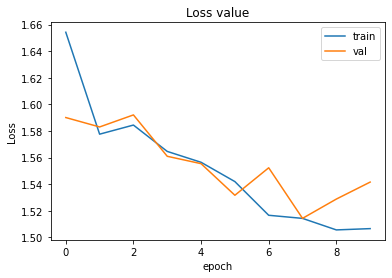

In [114]:
plt.plot(losses)
plt.plot(val_losses)
plt.title('Loss value')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

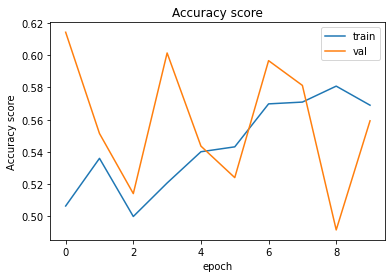

In [115]:
plt.plot(accs)
plt.plot(val_accs)

plt.title('Accuracy score')
plt.ylabel('Accuracy score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [116]:
preds = []
true = []
for texts, y in test_dataloader:   
    preds.extend(torch.argmax(model(texts), dim=1).cpu().detach().numpy())
    true.extend(y.cpu().detach().numpy())
print(classification_report(true, preds))

              precision    recall  f1-score   support

         0.0       0.24      0.30      0.26       314
         1.0       0.00      0.00      0.00       156
         2.0       0.84      0.87      0.86      1810
         3.0       0.16      0.96      0.27       157
         4.0       0.38      0.31      0.34       892
         5.0       0.62      0.33      0.43      1368

    accuracy                           0.54      4697
   macro avg       0.37      0.46      0.36      4697
weighted avg       0.60      0.54      0.55      4697



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


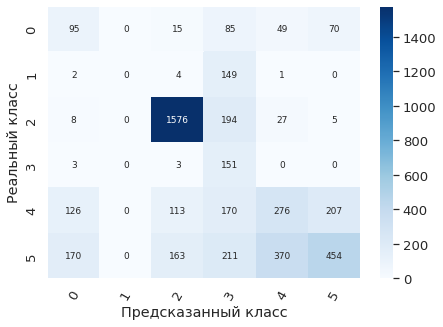

In [122]:
y_pred = preds
y_test = true
plt.figure(figsize=(7,5))
array=confusion_matrix(y_test, y_pred)
a = [sorted(test_df['target'].unique())]
df_cm = pd.DataFrame(array, index=a, columns=a)
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={'size':9}, cmap='Blues',fmt='g')
plt.xticks(rotation=60)
plt.xlabel('Предсказанный класс')
plt.ylabel('Реальный класс')
# plt.savefig('image.png')
plt.show()

ООО, стало получше! У нас, во-первых, маленькие классы, благодаря добавлению весов в кросс-энтропию, стали худо-бедно опознаваться моделью, но, как и предполагалось раннее, все равно классы-малыши  определяются моделью как какой-то из больших, но сейчас это прям сильно меньше!!!!

Кажется, переобучение тоже немножко случилось в этот раз, но, вообще-то, извините, на свертке, которые могут "грешить" переобучениями, и так дропаут 0.5, это очень много!

Попробуем поперебирать гиперпараметры, вдруг что получится

Еще хочу добавить расписание, вдруг это немножко поможет!

# Эксперимент 3

In [135]:
model = CLSTM(len(word2id))
#базовые из статьи параметры (цитирование выше было)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(ce_weights).to(device))
n_epochs = 10
losses, val_losses, accs, val_accs = train(train_dataloader,
                                                                           test_dataloader,
                                                                           model,
                                                                           optimizer,
                                                                           criterion,
                                                                           epochs=n_epochs,
                                                                           metric=accuracy, 
                                           scheduler=scheduler)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
TRAIN Loss: 1.71, TRAIN Metric: 0.44999998807907104


 10%|█         | 1/10 [01:22<12:24, 82.68s/it]

VAL Loss: 1.65, VAL Metric: 0.5799999833106995
----------
Epoch 2:
TRAIN Loss: 1.62, TRAIN Metric: 0.5


 20%|██        | 2/10 [02:47<11:11, 83.95s/it]

VAL Loss: 1.57, VAL Metric: 0.5899999737739563
----------
Epoch 3:
TRAIN Loss: 1.58, TRAIN Metric: 0.5199999809265137


 30%|███       | 3/10 [04:10<09:44, 83.50s/it]

VAL Loss: 1.58, VAL Metric: 0.6000000238418579
----------
Epoch 4:
TRAIN Loss: 1.58, TRAIN Metric: 0.550000011920929


 40%|████      | 4/10 [05:32<08:18, 83.04s/it]

VAL Loss: 1.58, VAL Metric: 0.5699999928474426
----------
Epoch 5:
TRAIN Loss: 1.55, TRAIN Metric: 0.5400000214576721


 50%|█████     | 5/10 [06:54<06:53, 82.63s/it]

VAL Loss: 1.56, VAL Metric: 0.5099999904632568
----------
Epoch 6:
TRAIN Loss: 1.53, TRAIN Metric: 0.5699999928474426


 60%|██████    | 6/10 [08:16<05:29, 82.41s/it]

VAL Loss: 1.52, VAL Metric: 0.5400000214576721
----------
Epoch 7:
TRAIN Loss: 1.53, TRAIN Metric: 0.5799999833106995


 70%|███████   | 7/10 [09:38<04:06, 82.19s/it]

VAL Loss: 1.54, VAL Metric: 0.6499999761581421
----------
Epoch 8:
TRAIN Loss: 1.52, TRAIN Metric: 0.5699999928474426


 80%|████████  | 8/10 [11:00<02:44, 82.03s/it]

VAL Loss: 1.52, VAL Metric: 0.6499999761581421
----------
Epoch 9:
TRAIN Loss: 1.51, TRAIN Metric: 0.5600000023841858


 90%|█████████ | 9/10 [12:27<01:23, 83.77s/it]

VAL Loss: 1.52, VAL Metric: 0.6000000238418579
----------
Epoch 10:
TRAIN Loss: 1.53, TRAIN Metric: 0.5600000023841858


100%|██████████| 10/10 [13:56<00:00, 83.68s/it]

VAL Loss: 1.51, VAL Metric: 0.5
----------


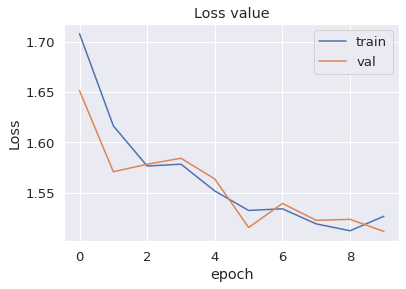

In [136]:
plt.plot(losses)
plt.plot(val_losses)
plt.title('Loss value')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

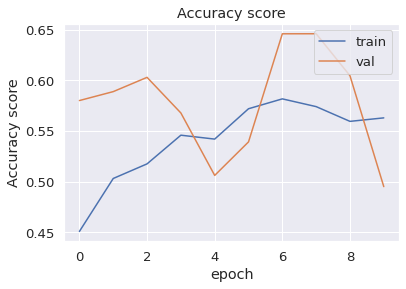

In [137]:
plt.plot(accs)
plt.plot(val_accs)
plt.title('Accuracy score')
plt.ylabel('Accuracy score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [138]:
preds = []
true = []
for texts, y in test_dataloader:   
    preds.extend(torch.argmax(model(texts), dim=1).cpu().detach().numpy())
    true.extend(y.cpu().detach().numpy())
print(classification_report(true, preds))

              precision    recall  f1-score   support

         0.0       0.17      0.69      0.28       314
         1.0       0.24      0.19      0.21       156
         2.0       0.97      0.72      0.83      1810
         3.0       0.29      0.71      0.41       157
         4.0       0.33      0.47      0.39       892
         5.0       0.69      0.16      0.26      1368

    accuracy                           0.49      4697
   macro avg       0.45      0.49      0.40      4697
weighted avg       0.67      0.49      0.51      4697



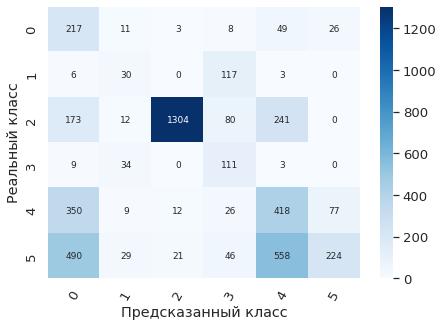

In [139]:
y_pred = preds
y_test = true
plt.figure(figsize=(7,5))
array=confusion_matrix(y_test, y_pred)
a = [sorted(test_df['target'].unique())]
df_cm = pd.DataFrame(array, index=a, columns=a)
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, annot_kws={'size':9}, cmap='Blues',fmt='g')
plt.xticks(rotation=60)
plt.xlabel('Предсказанный класс')
plt.ylabel('Реальный класс')
# plt.savefig('image.png')
plt.show()

Общая accuracy меньше, но О БОГИ, у нас класс-малыш наконец-то стал детектиться моделькой
Конецно, и лосс ровнее падал (и не похоже ни капли на переобучение модели!)
Так точно стабильнее обучение, доверяем этим метрикам, в экспериментах оставим шедулер и веса в кросс-энтропии!!!

In [144]:
def plot_losses(losses, val_losses):
  plt.plot(losses)
  plt.plot(val_losses)
  plt.title('Loss value')
  plt.ylabel('Loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

def plot_metrics(accs, val_accs):
  plt.plot(accs)
  plt.plot(val_accs)
  plt.title('Accuracy score')
  plt.ylabel('Accuracy score')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

def conf_matrix(preds, true):
  y_pred = preds
  y_test = true
  plt.figure(figsize=(7,5))
  array=confusion_matrix(y_test, y_pred)
  a = [0, 1, 2, 3, 4, 5]
  df_cm = pd.DataFrame(array, index=a, columns=a)
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={'size':9}, cmap='Blues',fmt='g')
  plt.xticks(rotation=60)
  plt.xlabel('Предсказанный класс')
  plt.ylabel('Реальный класс')
  # plt.savefig('image.png')
  plt.show()

In [143]:
# [sorted(test_df['target'].unique())]

[[0, 1, 2, 3, 4, 5]]

# Куча экспериментов

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1:
TRAIN Loss: 1.66, TRAIN Metric: 0.5299999713897705


 14%|█▍        | 1/7 [01:21<08:10, 81.72s/it]

VAL Loss: 1.6, VAL Metric: 0.46000000834465027
----------
Epoch 2:
TRAIN Loss: 1.59, TRAIN Metric: 0.5299999713897705


 29%|██▊       | 2/7 [02:43<06:48, 81.74s/it]

VAL Loss: 1.58, VAL Metric: 0.5299999713897705
----------
Epoch 3:
TRAIN Loss: 1.57, TRAIN Metric: 0.5600000023841858


 43%|████▎     | 3/7 [04:04<05:26, 81.53s/it]

VAL Loss: 1.57, VAL Metric: 0.5699999928474426
----------
Epoch 4:
TRAIN Loss: 1.56, TRAIN Metric: 0.550000011920929


 57%|█████▋    | 4/7 [05:30<04:09, 83.10s/it]

VAL Loss: 1.55, VAL Metric: 0.5899999737739563
----------
Epoch 5:
TRAIN Loss: 1.57, TRAIN Metric: 0.5099999904632568


 71%|███████▏  | 5/7 [06:52<02:45, 82.63s/it]

VAL Loss: 1.55, VAL Metric: 0.5400000214576721
----------
Epoch 6:
TRAIN Loss: 1.55, TRAIN Metric: 0.5600000023841858


 86%|████████▌ | 6/7 [08:13<01:22, 82.16s/it]

VAL Loss: 1.59, VAL Metric: 0.5299999713897705
----------
Epoch 7:
TRAIN Loss: 1.53, TRAIN Metric: 0.550000011920929


100%|██████████| 7/7 [09:34<00:00, 82.07s/it]

VAL Loss: 1.53, VAL Metric: 0.6000000238418579
----------
EXPERIMENT 0: dropout_place:
{0}
dropout_probability:  0.4




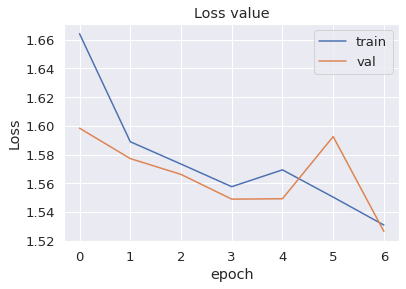

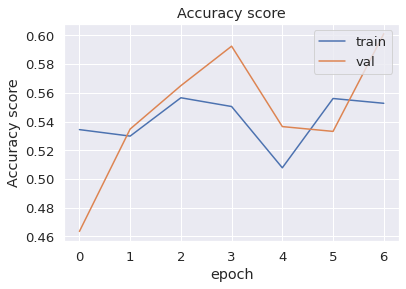

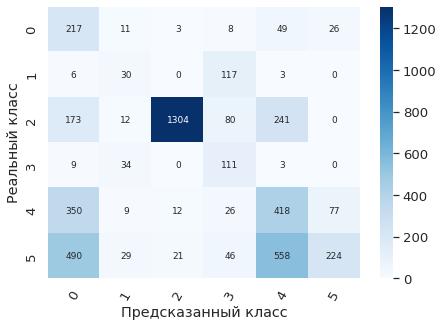

------


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1:
TRAIN Loss: 1.67, TRAIN Metric: 0.5299999713897705


 14%|█▍        | 1/7 [01:21<08:06, 81.13s/it]

VAL Loss: 1.59, VAL Metric: 0.5099999904632568
----------
Epoch 2:
TRAIN Loss: 1.59, TRAIN Metric: 0.5199999809265137


 29%|██▊       | 2/7 [02:41<06:44, 80.84s/it]

VAL Loss: 1.61, VAL Metric: 0.4000000059604645
----------
Epoch 3:
TRAIN Loss: 1.56, TRAIN Metric: 0.550000011920929


 43%|████▎     | 3/7 [04:02<05:23, 80.85s/it]

VAL Loss: 1.58, VAL Metric: 0.6299999952316284
----------
Epoch 4:
TRAIN Loss: 1.55, TRAIN Metric: 0.5600000023841858


 57%|█████▋    | 4/7 [05:23<04:03, 81.00s/it]

VAL Loss: 1.57, VAL Metric: 0.6000000238418579
----------
Epoch 5:
TRAIN Loss: 1.54, TRAIN Metric: 0.5400000214576721


 71%|███████▏  | 5/7 [06:45<02:42, 81.10s/it]

VAL Loss: 1.54, VAL Metric: 0.5099999904632568
----------
Epoch 6:
TRAIN Loss: 1.51, TRAIN Metric: 0.5600000023841858


 86%|████████▌ | 6/7 [08:06<01:21, 81.08s/it]

VAL Loss: 1.51, VAL Metric: 0.550000011920929
----------
Epoch 7:
TRAIN Loss: 1.5, TRAIN Metric: 0.5799999833106995


100%|██████████| 7/7 [09:27<00:00, 81.12s/it]

VAL Loss: 1.51, VAL Metric: 0.6000000238418579
----------
EXPERIMENT 1: dropout_place:
{1}
dropout_probability:  0.4




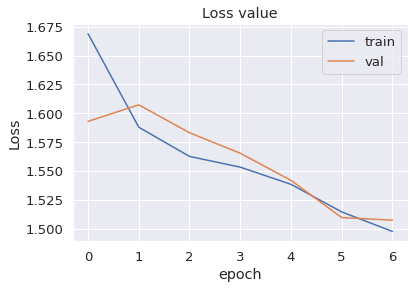

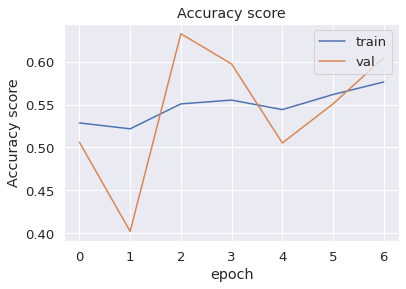

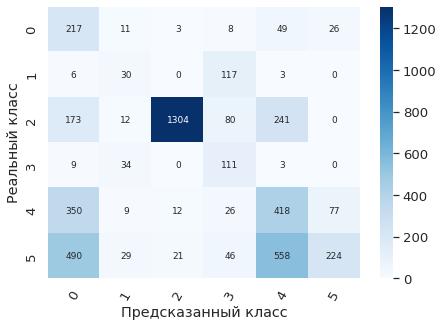

------


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1:
TRAIN Loss: 1.65, TRAIN Metric: 0.5199999809265137


 14%|█▍        | 1/7 [01:21<08:10, 81.80s/it]

VAL Loss: 1.59, VAL Metric: 0.5199999809265137
----------
Epoch 2:
TRAIN Loss: 1.58, TRAIN Metric: 0.5299999713897705


 29%|██▊       | 2/7 [02:43<06:49, 81.82s/it]

VAL Loss: 1.56, VAL Metric: 0.5600000023841858
----------
Epoch 3:
TRAIN Loss: 1.57, TRAIN Metric: 0.5199999809265137


 43%|████▎     | 3/7 [04:05<05:26, 81.65s/it]

VAL Loss: 1.55, VAL Metric: 0.4300000071525574
----------
Epoch 4:
TRAIN Loss: 1.54, TRAIN Metric: 0.550000011920929


 57%|█████▋    | 4/7 [05:25<04:03, 81.32s/it]

VAL Loss: 1.54, VAL Metric: 0.46000000834465027
----------
Epoch 5:
TRAIN Loss: 1.53, TRAIN Metric: 0.550000011920929


 71%|███████▏  | 5/7 [06:47<02:42, 81.26s/it]

VAL Loss: 1.52, VAL Metric: 0.5799999833106995
----------
Epoch 6:
TRAIN Loss: 1.54, TRAIN Metric: 0.5400000214576721


 86%|████████▌ | 6/7 [08:08<01:21, 81.20s/it]

VAL Loss: 1.51, VAL Metric: 0.5799999833106995
----------
Epoch 7:
TRAIN Loss: 1.51, TRAIN Metric: 0.5699999928474426


100%|██████████| 7/7 [09:29<00:00, 81.33s/it]

VAL Loss: 1.54, VAL Metric: 0.4399999976158142
----------
EXPERIMENT 2: dropout_place:
{0, 1}
dropout_probability:  0.4




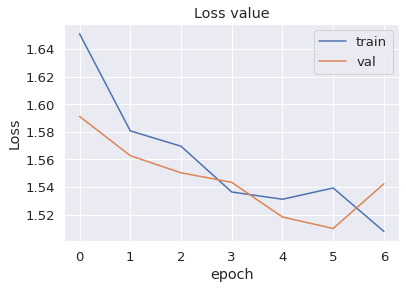

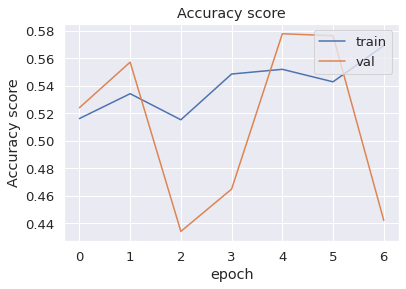

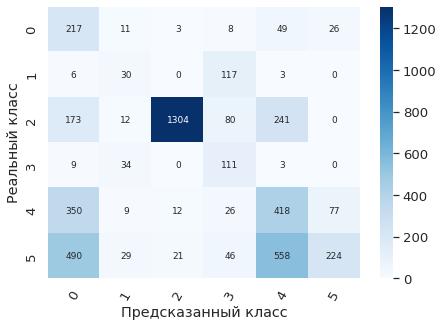

------


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1:
TRAIN Loss: 1.67, TRAIN Metric: 0.5400000214576721


 14%|█▍        | 1/7 [01:21<08:10, 81.69s/it]

VAL Loss: 1.59, VAL Metric: 0.6299999952316284
----------
Epoch 2:
TRAIN Loss: 1.59, TRAIN Metric: 0.5699999928474426


 29%|██▊       | 2/7 [02:43<06:48, 81.72s/it]

VAL Loss: 1.62, VAL Metric: 0.5799999833106995
----------
Epoch 3:
TRAIN Loss: 1.58, TRAIN Metric: 0.5400000214576721


 43%|████▎     | 3/7 [04:05<05:26, 81.73s/it]

VAL Loss: 1.58, VAL Metric: 0.5600000023841858
----------
Epoch 4:
TRAIN Loss: 1.54, TRAIN Metric: 0.550000011920929


 57%|█████▋    | 4/7 [05:26<04:04, 81.51s/it]

VAL Loss: 1.53, VAL Metric: 0.5099999904632568
----------
Epoch 5:
TRAIN Loss: 1.52, TRAIN Metric: 0.5600000023841858


 71%|███████▏  | 5/7 [06:47<02:42, 81.44s/it]

VAL Loss: 1.52, VAL Metric: 0.5799999833106995
----------
Epoch 6:
TRAIN Loss: 1.52, TRAIN Metric: 0.5799999833106995


 86%|████████▌ | 6/7 [08:09<01:21, 81.57s/it]

VAL Loss: 1.51, VAL Metric: 0.5299999713897705
----------
Epoch 7:
TRAIN Loss: 1.51, TRAIN Metric: 0.5699999928474426


100%|██████████| 7/7 [09:31<00:00, 81.62s/it]

VAL Loss: 1.51, VAL Metric: 0.5699999928474426
----------
EXPERIMENT 3: dropout_place:
{0}
dropout_probability:  0.5




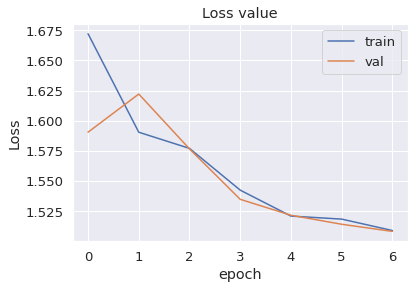

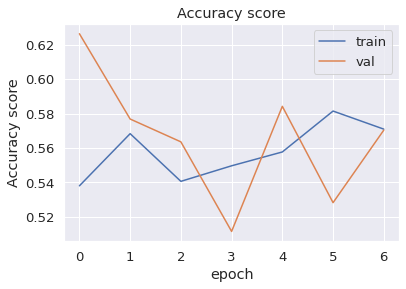

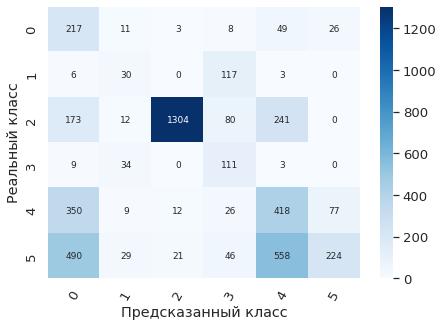

------


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1:
TRAIN Loss: 1.7, TRAIN Metric: 0.47999998927116394


 14%|█▍        | 1/7 [01:21<08:07, 81.24s/it]

VAL Loss: 1.65, VAL Metric: 0.6200000047683716
----------
Epoch 2:
TRAIN Loss: 1.64, TRAIN Metric: 0.5


 29%|██▊       | 2/7 [02:41<06:44, 80.83s/it]

VAL Loss: 1.66, VAL Metric: 0.28999999165534973
----------
Epoch 3:
TRAIN Loss: 1.57, TRAIN Metric: 0.550000011920929


 43%|████▎     | 3/7 [04:01<05:22, 80.54s/it]

VAL Loss: 1.55, VAL Metric: 0.550000011920929
----------
Epoch 4:
TRAIN Loss: 1.55, TRAIN Metric: 0.5400000214576721


 57%|█████▋    | 4/7 [05:22<04:01, 80.55s/it]

VAL Loss: 1.53, VAL Metric: 0.5699999928474426
----------
Epoch 5:
TRAIN Loss: 1.53, TRAIN Metric: 0.550000011920929


 71%|███████▏  | 5/7 [06:43<02:41, 80.68s/it]

VAL Loss: 1.52, VAL Metric: 0.5799999833106995
----------
Epoch 6:
TRAIN Loss: 1.52, TRAIN Metric: 0.5699999928474426


 86%|████████▌ | 6/7 [08:04<01:20, 80.64s/it]

VAL Loss: 1.51, VAL Metric: 0.5899999737739563
----------
Epoch 7:
TRAIN Loss: 1.5, TRAIN Metric: 0.5799999833106995


100%|██████████| 7/7 [09:25<00:00, 80.72s/it]

VAL Loss: 1.57, VAL Metric: 0.4000000059604645
----------
EXPERIMENT 4: dropout_place:
{1}
dropout_probability:  0.5




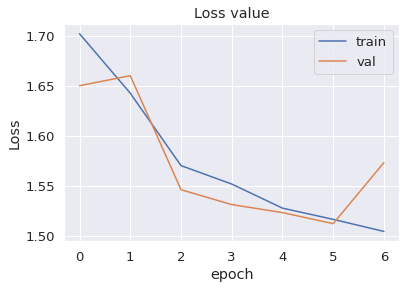

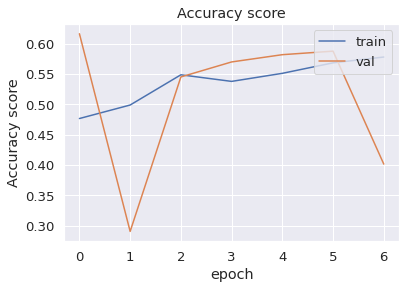

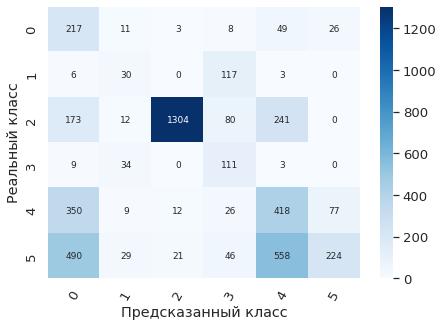

------


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1:
TRAIN Loss: 1.7, TRAIN Metric: 0.46000000834465027


 14%|█▍        | 1/7 [01:21<08:06, 81.01s/it]

VAL Loss: 1.59, VAL Metric: 0.5699999928474426
----------
Epoch 2:
TRAIN Loss: 1.59, TRAIN Metric: 0.5400000214576721


 29%|██▊       | 2/7 [02:42<06:47, 81.55s/it]

VAL Loss: 1.57, VAL Metric: 0.5799999833106995
----------
Epoch 3:
TRAIN Loss: 1.58, TRAIN Metric: 0.5400000214576721


 43%|████▎     | 3/7 [04:04<05:26, 81.67s/it]

VAL Loss: 1.69, VAL Metric: 0.6299999952316284
----------
Epoch 4:
TRAIN Loss: 1.6, TRAIN Metric: 0.5600000023841858


 57%|█████▋    | 4/7 [05:25<04:04, 81.43s/it]

VAL Loss: 1.56, VAL Metric: 0.5299999713897705
----------
Epoch 5:
TRAIN Loss: 1.55, TRAIN Metric: 0.550000011920929


 71%|███████▏  | 5/7 [06:47<02:43, 81.60s/it]

VAL Loss: 1.54, VAL Metric: 0.550000011920929
----------
Epoch 6:
TRAIN Loss: 1.55, TRAIN Metric: 0.550000011920929


 86%|████████▌ | 6/7 [08:09<01:21, 81.57s/it]

VAL Loss: 1.53, VAL Metric: 0.6000000238418579
----------
Epoch 7:
TRAIN Loss: 1.58, TRAIN Metric: 0.47999998927116394


100%|██████████| 7/7 [09:30<00:00, 81.52s/it]

VAL Loss: 1.54, VAL Metric: 0.5199999809265137
----------
EXPERIMENT 5: dropout_place:
{0, 1}
dropout_probability:  0.5




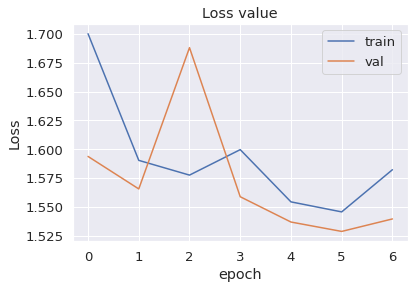

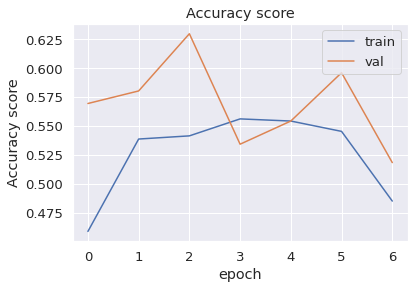

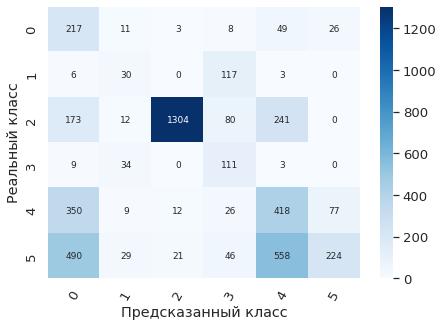

------


In [147]:
e = 0
for dropout_p in [0.4, 0.5]:
  for dropout_place in [set([0]), set([1]), set([0,1])]:
            num_filters = 150 
            lstm_layers = 1  

            model = CLSTM(vocab_size=len(word2id),
                          embedding_size=300,
                          output_dim=num_classes,
                          max_len=max_len,
                          filter_sizes=[2, 3, 4],
                          memory_dim=150,
                          num_filters=150,
                          lstm_layers=lstm_layers, 
                          dropout_places=dropout_place,
                          )
            optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
            criterion = nn.CrossEntropyLoss(weight=torch.Tensor(ce_weights).to(device))
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
            n_epochs = 7 # я поставила поменньмше, потому что не терпелось узнать результаты
            losses, val_losses, accs, val_accs = train(train_dataloader,
                                                                           test_dataloader,
                                                                           model,
                                                                           optimizer,
                                                                           criterion,
                                                                           epochs=n_epochs,
                                                                           metric=accuracy, 
                                           scheduler=scheduler)
            print(f'EXPERIMENT {e}: dropout_place:')
            print(dropout_place)
            print('dropout_probability: ', str(dropout_p))
            print('\n')
            plot_losses(losses, val_losses)
            plot_metrics(accs, val_accs)
            conf_matrix(preds, true)
            e += 1
            print('------')

В серии конкретных экспериментов лучшие метрики получились при таком раскладе:

dropout_place накладывается только на embeddings со сверток
dropout_probability:  0.4

оптимайзер, как в статье RMSprop (я бы поменяла точно бы на Adam!!!)

шедулер оставила бы, потому что обучение стало стабильнее

тема с весами обратной частотности классов в кросс-энтропии - СУПЕР!

Как это заметно на протяжении всей истории экспериментов, классы 4 и 5 часто смешиваются моделью между собой - это классы "left-news" и "politics". Посмотрев на них "глазами", я бы правда и сама не так однозначно бы отнесла к тому или иному классу.

Опять же, есть всегда возможность пост-переразметки данных, например, по анализу ошибок модели и дальнейшего усовершенствования датасета. Также в целом проблема несбалансированного датасета никуда не делась, хотя, как мне кажется, я очень красиво ее обошла, и это, как мне кажется, было одной из главных причин улучшения model performance, как говорится


Эксперименты с некотороми гиперпараметрами особой погоды не сделали - надо сказать, что я не копошилась в других параметрах, потому что просто почитала про проблему, например, выбора значения параметра num_filters ([здесь](https://habr.com/ru/company/wunderfund/blog/331310/), [здесь](https://medium.com/smileinnovation/how-to-work-with-time-distributed-data-in-a-neural-network-b8b39aa4ce00) и [здесь](https://neerc.ifmo.ru/wiki/index.php?title=Долгая_краткосрочная_память)), что лучше отсавить параметр, как в статье, как есть, потому что есть риски либо "выхода на плато" модели, либо "недообучения", также я не стала менять параметр, например, memory_dim, потому что хотела его попробовать увеличить немного, но у меня "вылетел" колаб и я решила оставить опцию небольшого перебора этого гиперпараметра "на потом".

Также не стоит забывать, что в оригинальной статье бралась длина последовательности 6000 токенов, а в наших экспериментах это только 250 опять же due to computational limits

В общем, мне показалось, что я красиво оформила все эксперименты и саму модель, которая соотвествует описанию в статье, еще я провела ряд экспериментов, однако есть, к чему стремиться и дальше, это нормальный процесс исследовательский.